# ML 201. Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

<a id="toc"></a>
# Содержание

* [TL;DR](#tldr)
* [Разведочный анализ данных](#eda)
 * [Загрузка и знакомство с данными](#load)
 * [Очистка данных](#cleanup)
 * [Дубликаты](#dups)
 * [Проверка полноты данных](#isna)
 * [Статистики](#stats)
* [Визуальный анализ](#graph)
 * [Гистограммы](#hist)
 * [Размахи](#boxes)
 * [Разделение признаков по классам](#swarms)
* [Предобработка](#pp)
 * [Tenure](#tenure)
 * [MonthlyCharges](#MonthlyCharges)
 * [TotalCharges](#TotalCharges)
 * [Перекодировка целевой переменной](#target_enc)
 * [Перекодировка категориальных переменных](#cats_enc)
* [Отбор признаков](#feat)
 * [Константные признаки](#const_feat)
 * [Связь с целевой переменной](#target_info)
 * [Одномерный ROC AUC анализ](#univariate)
 * [Корреляция](#corr)
* [Утилиты](#utils)
 * [Метрики](#metrics)
 * [Визуализация результатов моделирования](#mlplot)
* [Моделирование](#utils)
 * [Разбиение данных на тестовую и обучающую выборки](#split)
 * [Точка отсчёта](#baseline)
 * [Моделирование с параметрами из коробки](#oob)
 * [Подбор параметров моделей с помощью RandomizedSearchCV](#search_cv)

<a id="tldr"></a>
# TL;DR [⇑](#toc)

Все модели превзошли наивную точку отсчёта.

Без подбора гиперпараметров абсолютный победитель — AdaBoost!
Второе место — градиентный бустинг от Sklearn.
Третье место — CatBoost.

Все модели с подобранными гиперпараметрами превзошли модели с параметрами из коробки.

После подбора гиперпараметров лидер уже не так очевиден.
По ROC AUC на первом месте CatBoost, на втором — Sklearn, на третьем — XGBoost.
Но первое и второе место отличаются только четвёртом знаке после запятой.
Третье — в третьем знаке, а все остальные — во втором.
Что интересно, AdaBoost из коробки показала те же 85%, что и модели с подбором параметров.

По метрикам Accuracy и F1 победил XGBoost.
По Recall — AdaBoost и XGBoost.

По Precision — CatBoost.

По совокупности метрик я бы на первое место поставил XGBoost.
Но это не точно, так как подбирались не все параметры моделей.

<a id="eda"></a>
# Разведочный анализ данных [⇑](#toc)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-colorblind')

random_state=42
np.random.seed(random_state)
np.set_printoptions(precision=3)

%matplotlib inline

<a id="load"></a>
## Загрузка и знакомство с данными [⇑](#toc)

In [2]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
data.sample(5).T

185                        2715  \
customerID              1024-GUALD                 0484-JPBRU   
gender                      Female                       Male   
SeniorCitizen                    0                          0   
Partner                        Yes                         No   
Dependents                      No                         No   
tenure                           1                         41   
PhoneService                    No                        Yes   
MultipleLines     No phone service                        Yes   
InternetService                DSL                         No   
OnlineSecurity                  No        No internet service   
OnlineBackup                    No        No internet service   
DeviceProtection                No        No internet service   
TechSupport                     No        No internet service   
StreamingTV                     No        No internet service   
StreamingMovies                 No        No internet service   
Contract            Month-to-month             Month-to-month   
PaperlessBilling               Yes                        Yes   
PaymentMethod     Electronic check  Bank transfer (automatic)   
MonthlyCharges                24.8                      25.25   
TotalCharges                  24.8                     996.45   
Churn                          Yes                         No   

                                 3825              1807  \
customerID                 3620-EHIMZ        6910-HADCM   
gender                         Female            Female   
SeniorCitizen                       0                 0   
Partner                           Yes                No   
Dependents                        Yes                No   
tenure                             52                 1   
PhoneService                      Yes               Yes   
MultipleLines                      No                No   
InternetService                    No       Fiber optic   
OnlineSecurity    No internet service                No   
OnlineBackup      No internet service                No   
DeviceProtection  No internet service               Yes   
TechSupport       No internet service                No   
StreamingTV       No internet service                No   
StreamingMovies   No internet service                No   
Contract                     Two year    Month-to-month   
PaperlessBilling                   No                No   
PaymentMethod            Mailed check  Electronic check   
MonthlyCharges                  19.35             76.35   
TotalCharges                   1031.7             76.35   
Churn                              No               Yes   

                                       132   
customerID                       8587-XYZSF  
gender                                 Male  
SeniorCitizen                             0  
Partner                                  No  
Dependents                               No  
tenure                                   67  
PhoneService                            Yes  
MultipleLines                            No  
InternetService                         DSL  
OnlineSecurity                           No  
OnlineBackup                             No  
DeviceProtection                         No  
TechSupport                             Yes  
StreamingTV                              No  
StreamingMovies                          No  
Contract                           Two year  
PaperlessBilling                         No  
PaymentMethod     Bank transfer (automatic)  
MonthlyCharges                        50.55  
TotalCharges                         3260.1  
Churn                                    No

In [5]:
# Целевая переменная
target = 'Churn'
hue_order=['Yes', 'No']

<a id="cleanup"></a>
### Очистка данных [⇑](#toc)

Уникальный идентификатор абонента <b>customerID</b> явно не нужен для модели, — удаляем.

In [6]:
# Уникальный идентификатор явно не нужен для модели.
data.drop(['customerID'], axis=1, inplace=True)

Признак <b>TotalCharges</b> по логике должен быть вещественным, но имеет тип object — похоже часть данных не числа.

In [7]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def as_number(s):
    try:
        return float(s)
    except ValueError:
        return np.Nan

In [8]:
data[~data['TotalCharges'].apply(is_number)]

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
488   Bank transfer (automatic)           52.55                 No  
753                Mailed check           20.25                 No  
936                Mailed check           80.85                 No  
1082               Mailed check           25.75                 No  
1340    Credit card (automatic)           56.05                 No  
3331               Mailed check           19.85                 No  
3826               Mailed check           25.35                 No  
4380               Mailed check           20.00                 No

Так и есть — пустые строки. Всего 11 записей, — удалю их.

In [9]:
data = data[data['TotalCharges'].apply(is_number)]
data['TotalCharges'] = data['TotalCharges'].apply(as_number)

In [10]:
# Все значения укладываются в типы данных меньшего размера, поэтому преобразую их для экономии памяти.
data = data.astype({'SeniorCitizen': np.int8, 'tenure': np.int8, 'MonthlyCharges': np.float32, 'TotalCharges': np.float32})

<a id="dups"></a>
### Дубликаты [⇑](#toc)

In [11]:
data.duplicated().value_counts()

False    7010
True       22
dtype: int64

In [12]:
data = data[~data.duplicated()]
data.shape

(7010, 20)

<a id="isna"></a>
### Проверка полноты данных [⇑](#toc)

In [13]:
incomplete = data.isna().mean()*100
print(incomplete[incomplete > 0])

Series([], dtype: float64)


<a id="stats"></a>
### Статистики [⇑](#toc)

In [14]:
data.describe(percentiles=[.25, .5, .75, .9, .95, .99]).T

count         mean          std        min       25%  \
SeniorCitizen   7010.0     0.162767     0.369180   0.000000    0.0000   
tenure          7010.0    32.520399    24.520441   1.000000    9.0000   
MonthlyCharges  7010.0    64.888802    30.064739  18.250000   35.7500   
TotalCharges    7010.0  2290.351318  2266.822266  18.799999  408.3125   

                        50%          75%          90%          95%  \
SeniorCitizen      0.000000     0.000000     1.000000     1.000000   
tenure            29.000000    56.000000    69.000000    72.000000   
MonthlyCharges    70.400002    89.900002   102.709998   107.449997   
TotalCharges    1403.875000  3807.837524  5980.569824  6927.824902   

                        99%          max  
SeniorCitizen      1.000000     1.000000  
tenure            72.000000    72.000000  
MonthlyCharges   114.745500   118.750000  
TotalCharges    8041.136929  8684.799805

In [15]:
data.describe(include=['object'])

gender Partner Dependents PhoneService MultipleLines InternetService  \
count    7010    7010       7010         7010          7010            7010   
unique      2       2          2            2             3               3   
top      Male      No         No          Yes            No     Fiber optic   
freq     3535    3617       4911         6330          3363            3090   

       OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
count            7010         7010             7010        7010        7010   
unique              3            3                3           3           3   
top                No           No               No          No          No   
freq             3489         3079             3086        3464        2801   

       StreamingMovies        Contract PaperlessBilling     PaymentMethod  \
count             7010            7010             7010              7010   
unique               3               3                2                 4   
top                 No  Month-to-month              Yes  Electronic check   
freq              2773            3853             4158              2359   

       Churn  
count   7010  
unique     2  
top       No  
freq    5153

In [16]:
data.groupby([target]).agg([np.mean, np.std, np.min, np.max])

SeniorCitizen                         tenure                       \
               mean       std amin amax       mean        std amin amax   
Churn                                                                     
No         0.129245  0.335504    0    1  37.721133  24.046039    1   72   
Yes        0.255789  0.436421    0    1  18.088853  19.546231    1   72   

      MonthlyCharges                               TotalCharges               \
                mean        std   amin        amax         mean          std   
Churn                                                                          
No         61.387417  31.071570  18.25  118.750000  2560.264160  2329.034634   
Yes        74.604309  24.597504  18.85  118.349998  1541.376587  1893.151018   

                               
            amin         amax  
Churn                          
No     18.799999  8672.450195  
Yes    18.850000  8684.799805

<a id="graph"></a>
# Визуальный анализ

In [17]:
sns.set_palette(palette=sns.husl_palette(2, l=0.5, s=.95))

<a id="targ_dist"></a>
### Распределение целевой переменной [⇑](#toc)

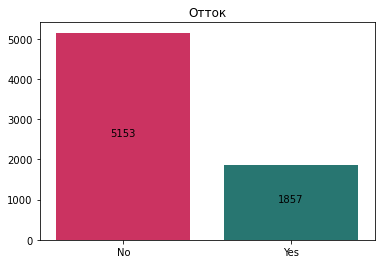

In [18]:
counts = data[target].value_counts(ascending=False)
pos = range(len(counts))

ax = sns.countplot(data[target])
for tick, label in zip(pos, ax.get_xticklabels()):
    plt.text(pos[tick], counts[tick] / 2 + 1, counts[tick], horizontalalignment='center', size='medium', color='black')

plt.title('Отток')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [19]:
data[target].value_counts(normalize=True)

No     0.735093
Yes    0.264907
Name: Churn, dtype: float64

Если модель будет безусловно предсказывать лояльность абонента для любых входных данных, то точность такой модели на тестовых данных будет примерно равна 73%.<br>
Это значение можно взять в качестве базовой линии при оценке качества обученной модели.

<a id="hist"></a>
### Гистограммы [⇑](#toc)

In [20]:
def plot_hist(nrows=5, ncols=4, hue=target, hue_order=hue_order):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 21))
    for i in range(0, nrows * ncols):
        y = (i // ncols) % nrows
        x = i % ncols
        sns.histplot(data=data, x=data[data.columns[i]], ax=ax[y][x], hue=hue, hue_order=hue_order, kde=False, bins=100)
        ax[y][x].set_ylabel('')
        
        if (x==0) and (y==4):
            ax[y][x].tick_params(axis='x', labelrotation=90)
        
    plt.tight_layout()
    plt.show()

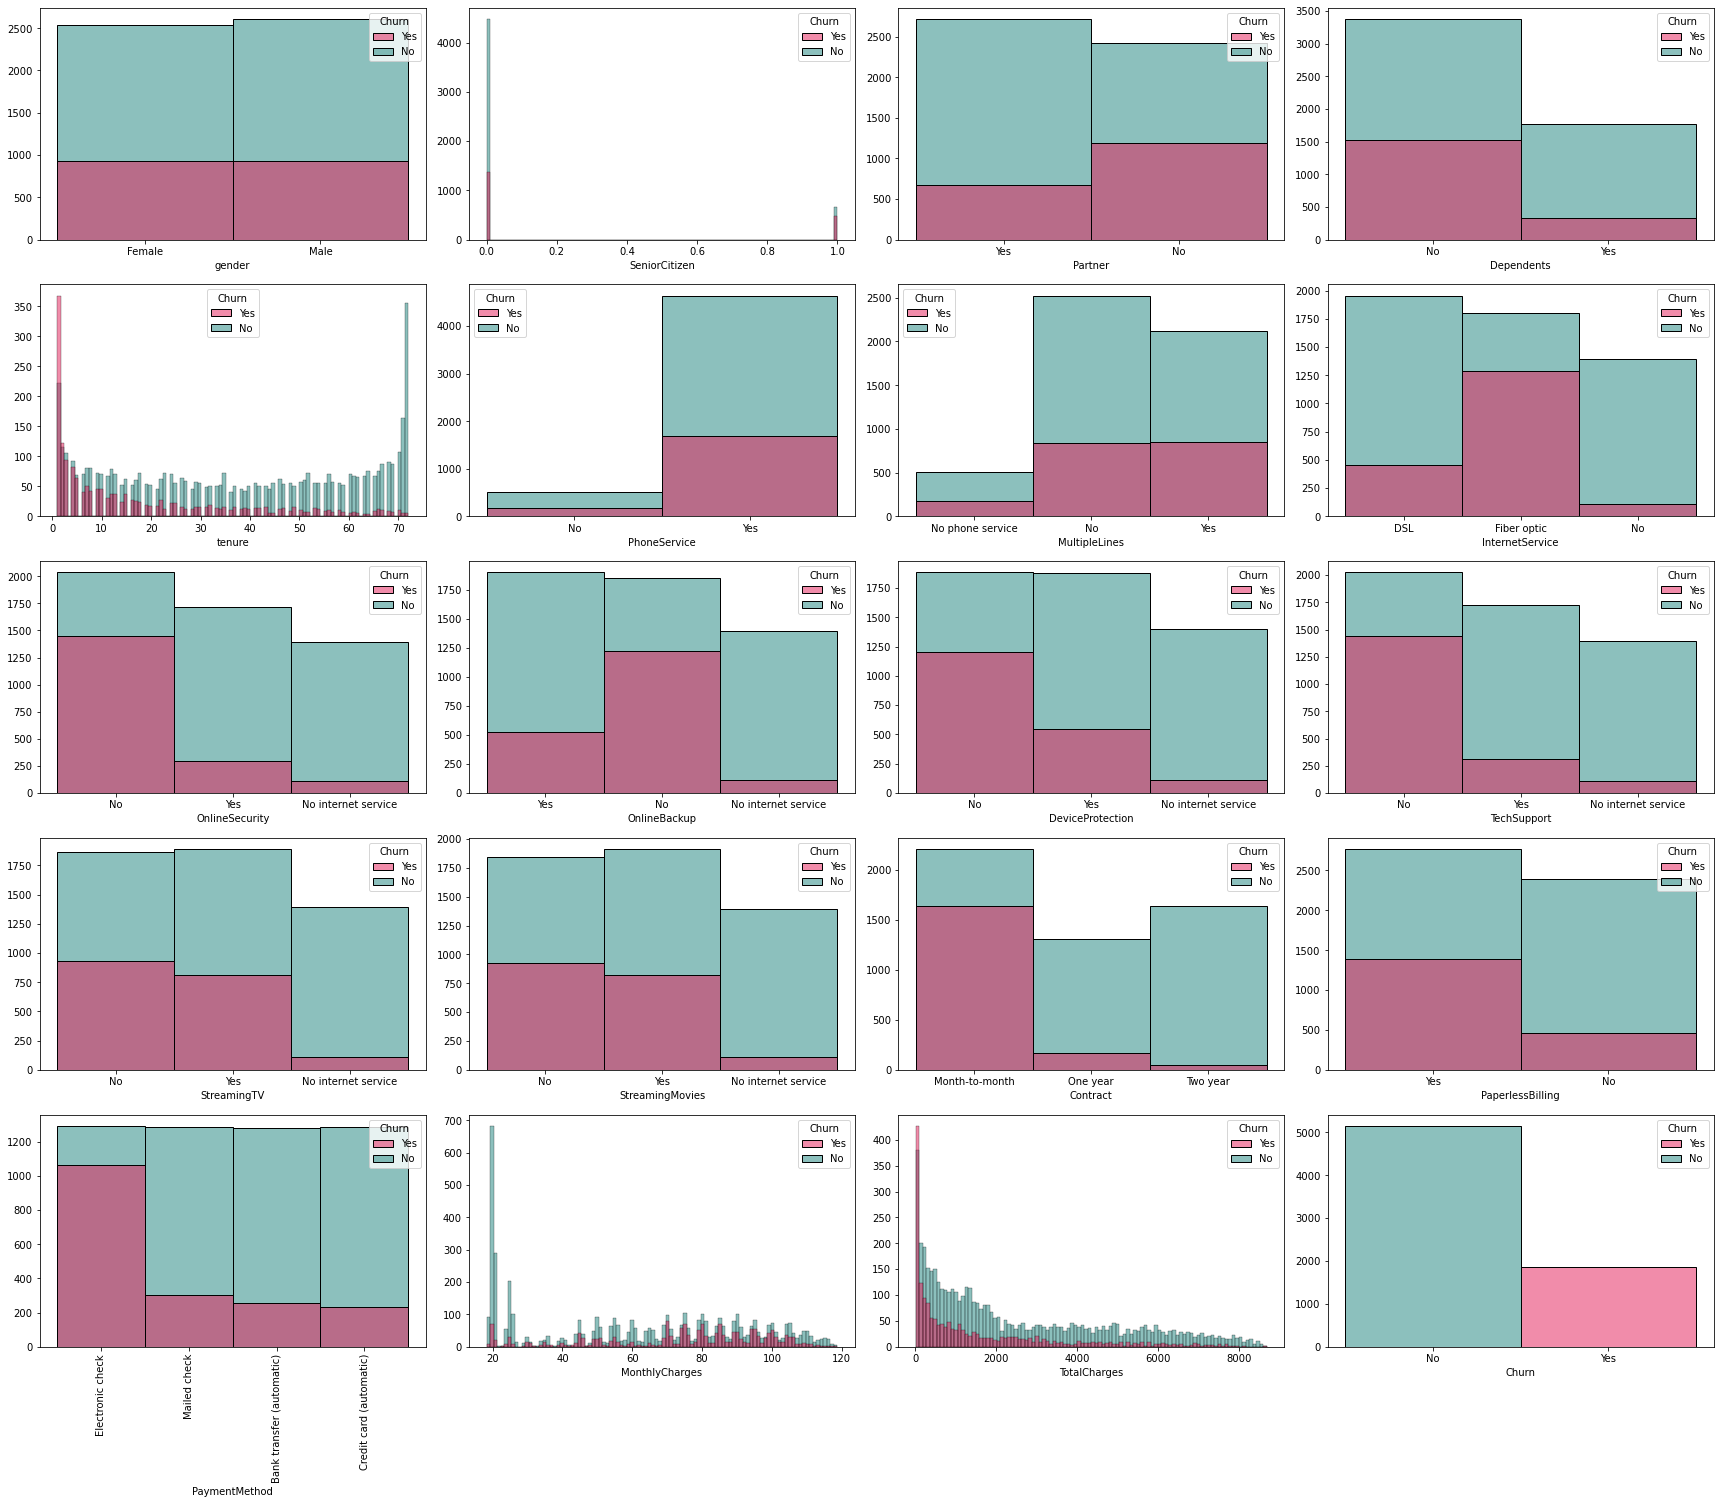

In [21]:
plot_hist()

Похоже, что пол абонента никак не влияет на лояльность. Так что можно попробовать выкинуть признак <b>gender</b> из модели.

<a id="boxes"></a>
### Размахи [⇑](#toc)

In [22]:
def plot_boxes_for(df, features, hue=target, hue_order=hue_order, add_jitter=True):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    feat_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index = df.index)
    data = pd.concat([df[hue], feat_scaled], axis=1)
    df_melt = pd.melt(frame=data, value_vars=features, id_vars=[hue])
    fig, ax = plt.subplots(1, 1, figsize = (15, 8), dpi=300)
    sns.boxplot(x='variable', y='value', hue=hue, hue_order=hue_order, data=df_melt, dodge=True)
    if add_jitter:
        sns.stripplot(x='variable', y='value', hue=hue, hue_order=hue_order, split=True, data=df_melt, linewidth=1, alpha=.5, dodge=True, jitter=0.2, size=2.5)
    plt.xticks(rotation=90)
    plt.ylabel('')
    plt.xlabel('')

    handles, labels = ax.get_legend_handles_labels()
    L=plt.legend(handles[0:2], labels[0:2])

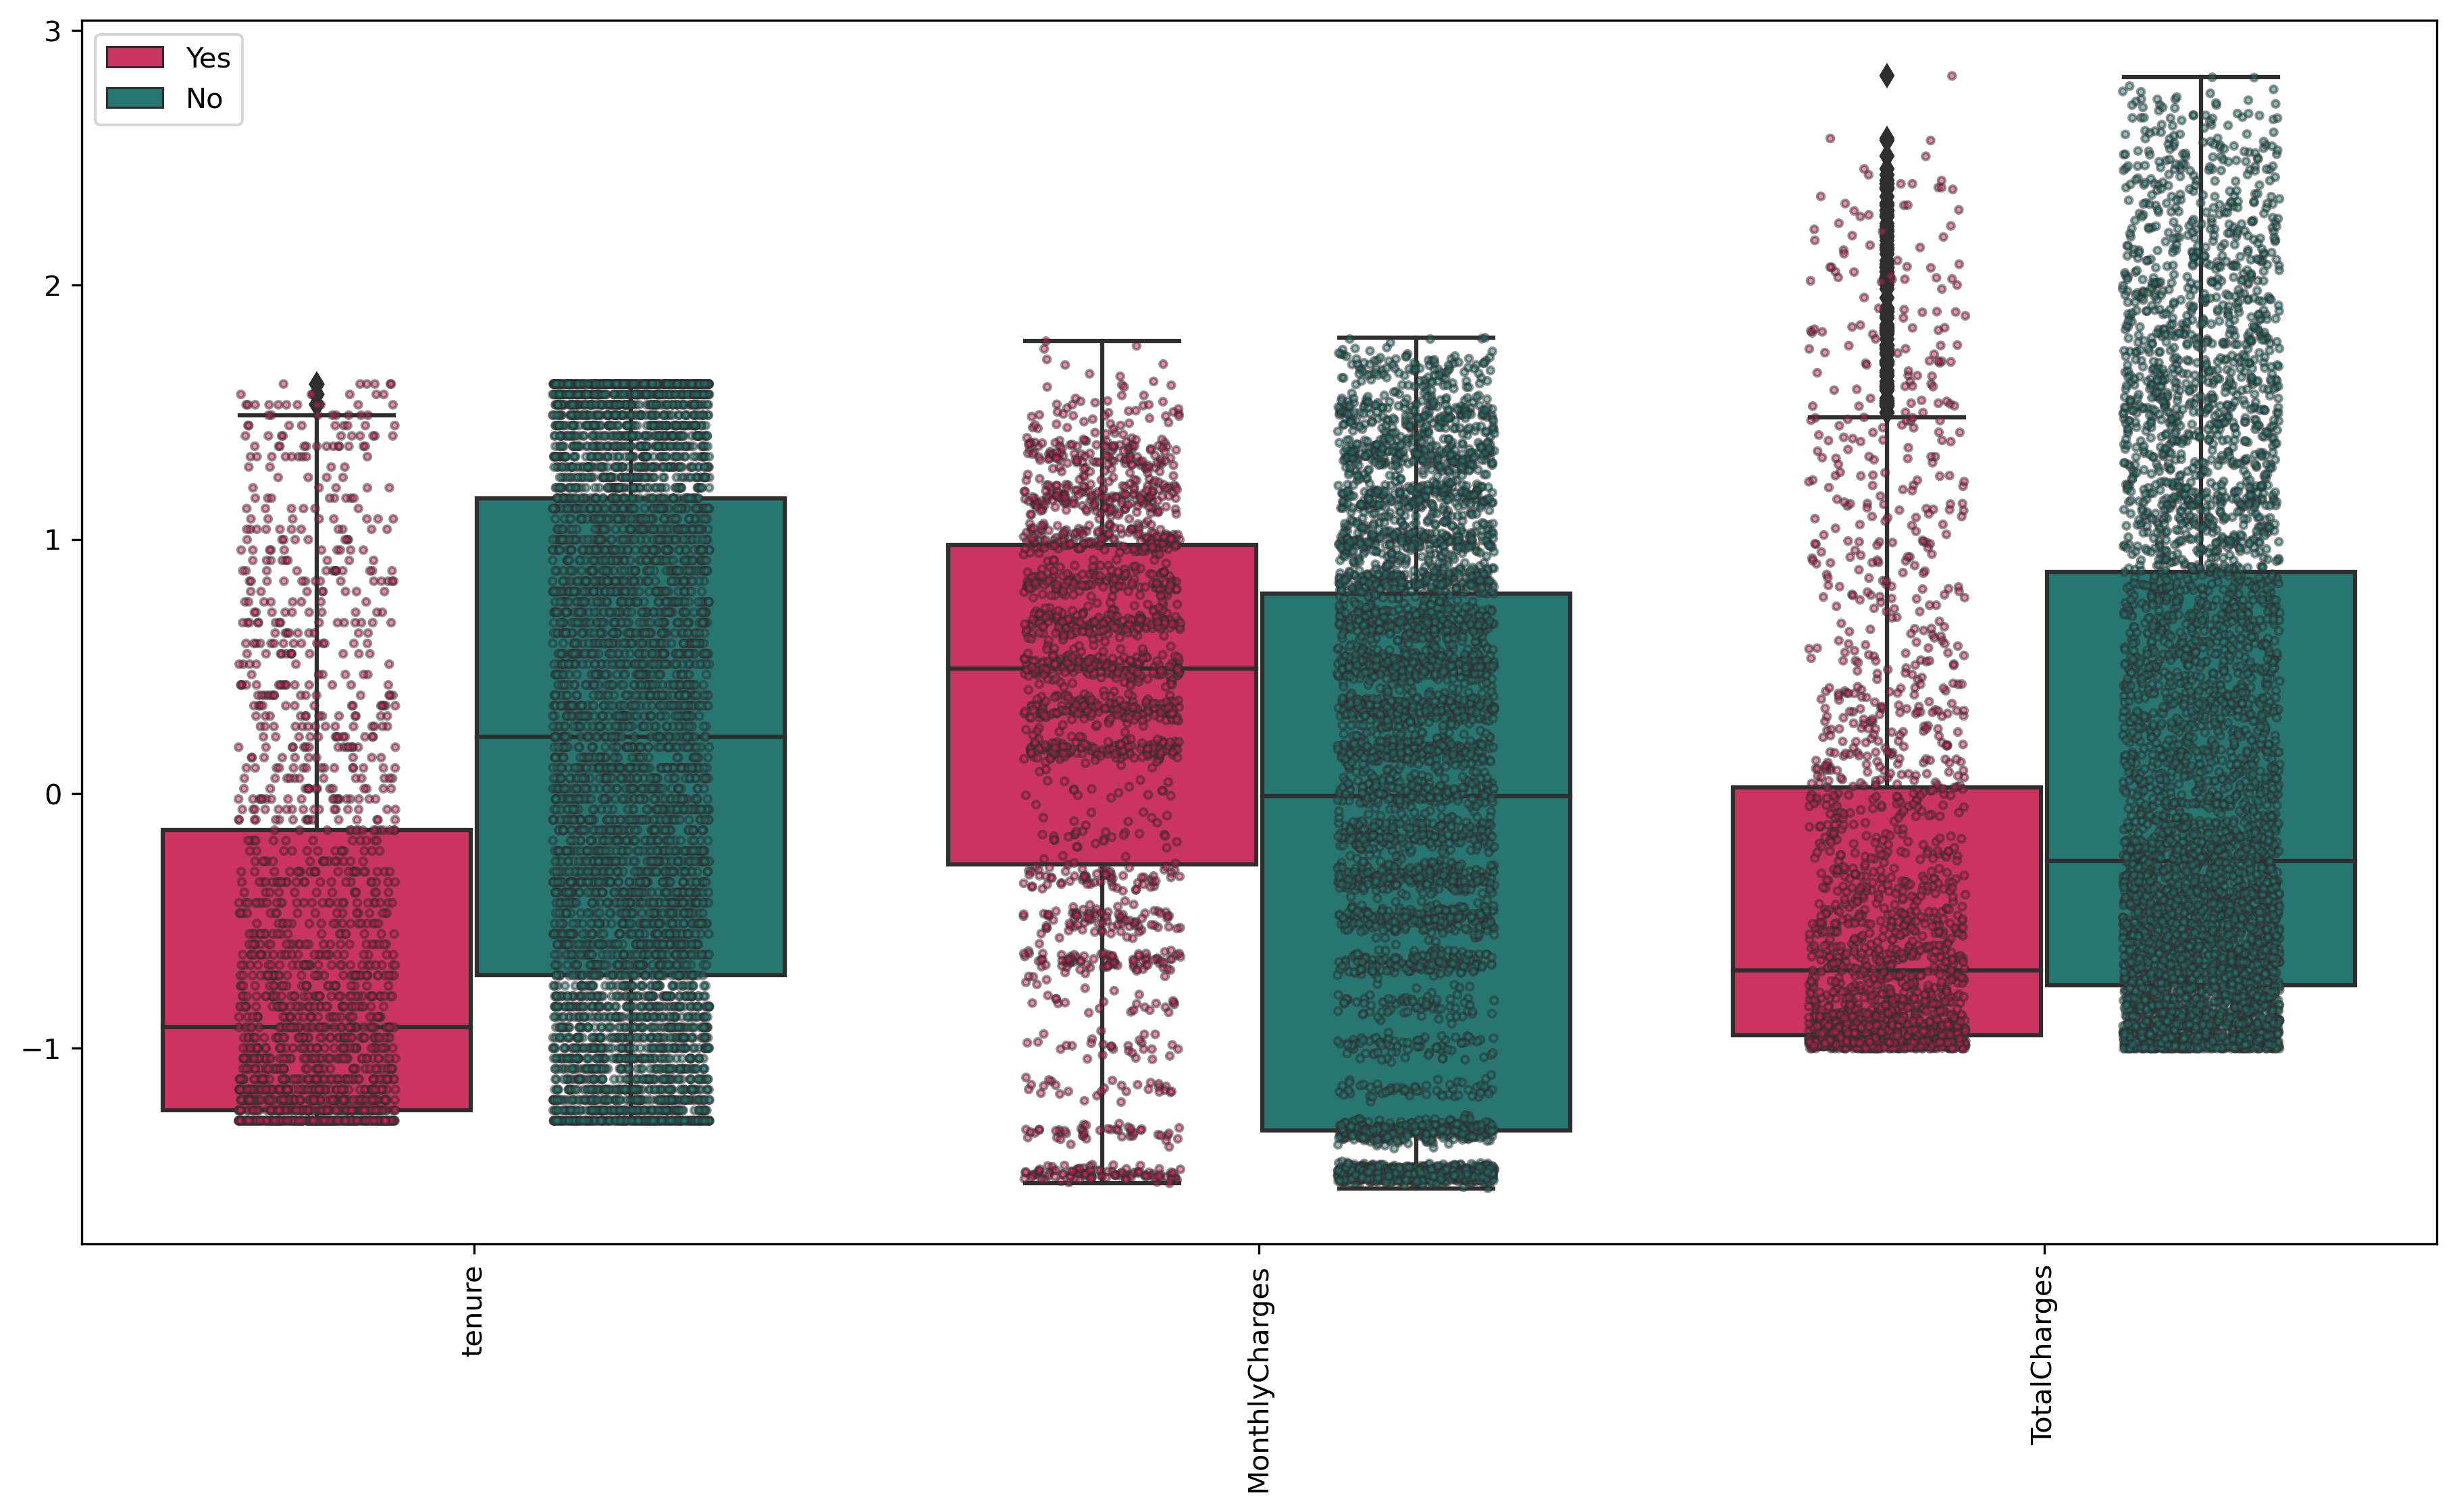

In [23]:
plot_boxes_for(df=data, features=['tenure', 'MonthlyCharges', 'TotalCharges'])

<a id="swarms"></a>
### Визуализация разделения признаков по классам [⇑](#toc)

In [24]:
def plot_swarm_for(df, features, hue=target, hue_order=hue_order, sample=1000):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    feat_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index = df.index)
    data = pd.concat([df[hue], feat_scaled], axis=1)
    if sample != None:
        data=data.sample(sample, random_state=random_state)
    df_melt = pd.melt(frame=data, value_vars=features, id_vars=[hue])
    fig, ax = plt.subplots(1, 1, figsize = (15, 8), dpi=300)
    sns.swarmplot(x='variable', y='value', hue=hue, hue_order=hue_order, data=df_melt)
    plt.xticks(rotation=90)
    plt.ylabel('')
    plt.xlabel('')
    sns.despine()
    plt.tight_layout()
    plt.show()

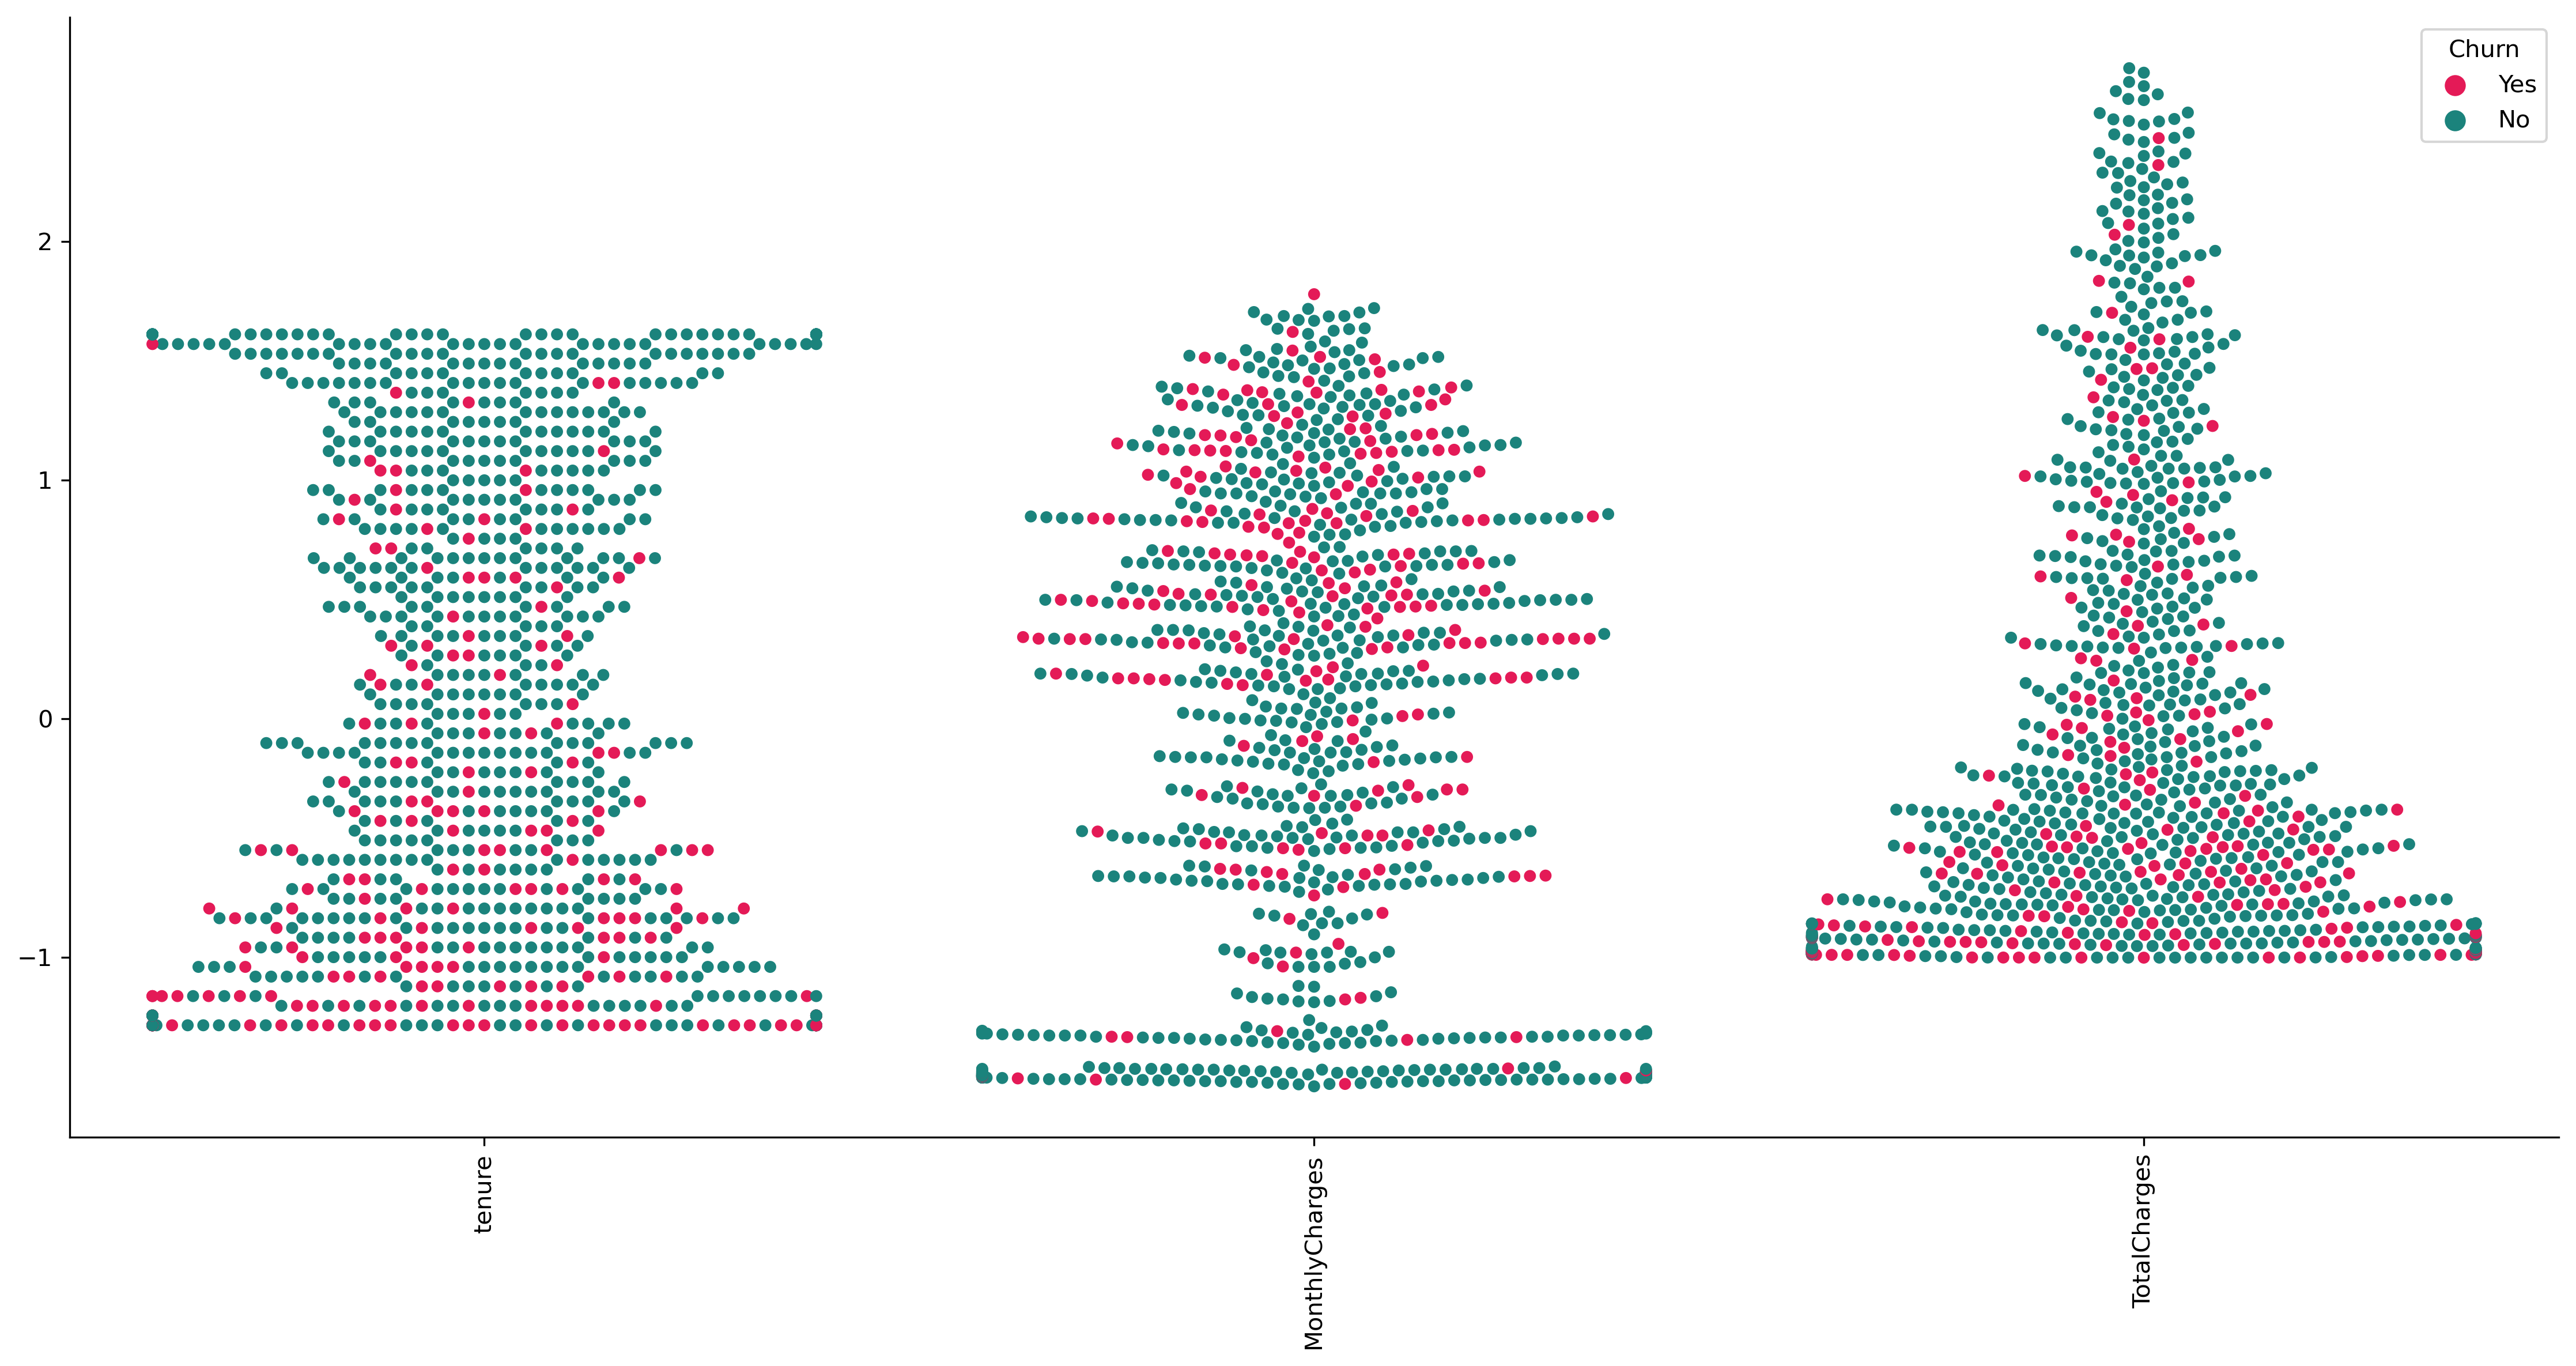

In [25]:
plot_swarm_for(df=data, features=['tenure', 'MonthlyCharges', 'TotalCharges'])

С натяжкой можно сказать, что <b>tenure</b> более менее разделяет на классы.

<a id="pp"></a>
# Предобработка [⇑](#toc)

In [26]:
def outlier_detect_IQR(data, col, threshold=3):   
    """Определяем выбросы через интерквартильное расстояние."""
    q25 = data[col].quantile(0.25)
    q75 = data[col].quantile(0.75)
    IQR = q75 - q25
    lower_fence = q25 - (IQR * threshold)
    upper_fence = q75 + (IQR * threshold)
    tmp = pd.concat([data[col] > upper_fence, data[col] < lower_fence], axis=1)
    outlier_index = tmp.any(axis=1)
    ovc = outlier_index.value_counts()

    if len(ovc) == 1:
        print('Выбросов нет')
    else:
        outlier_count = outlier_index.value_counts()[1]
        print('Количество выбросов в данных:', outlier_count)
        print('Доля выбросов:', f'{(100 * outlier_count / len(outlier_index)):.2f}%')
        print('Верхняя граница:', upper_fence, '\nНижняя граница:', lower_fence)

    return outlier_index, lower_fence, upper_fence

def drop_outlier(data, outlier_index):
    """Выкидываем выбросы."""
    data_copy = data[~outlier_index]
    return data_copy

<a id="tenure"></a>
### Tenure [⇑](#toc)

In [27]:
tenure_out_index, tenure_out_low, tenure_out_up = outlier_detect_IQR(data=data, col='tenure', threshold=5)

Выбросов нет


<a id="MonthlyCharges"></a>
### MonthlyCharges [⇑](#toc)

In [28]:
monthly_charges_out_index, monthly_charges_out_low, monthly_charges_out_up = outlier_detect_IQR(data=data, col='MonthlyCharges', threshold=5)

Выбросов нет


<a id="TotalCharges"></a>
### TotalCharges [⇑](#toc)

In [29]:
total_charges_out_index, total_charges_out_low,total_charges_out_up = outlier_detect_IQR(data=data, col='TotalCharges', threshold=5)

Выбросов нет


<a id="target_enc"></a>
## Перекодировка целевой переменной [⇑](#toc)

In [30]:
data[target] = data[target].apply(lambda x : 0 if x=='No' else 1)

<a id="cats_enc"></a>
## Перекодировка категориальных переменных [⇑](#toc)

In [31]:
from sklearn.preprocessing import LabelEncoder

class LabelEncoderDf:
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()

        if self.columns is None:
            self.columns = output.columns[output.dtypes=='object'].tolist()
            
        for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [32]:
data = LabelEncoderDf().fit_transform(data)

<a id="feat"></a>
# Отбор признаков [⇑](#toc)

In [33]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

def constant_feature_detect(data, threshold=0.98):  
    """Проверяем, что доля самой популярной значением фичи больше ``threshold``."""
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = data_copy[feature].value_counts(normalize=True).max()
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature), 'константные переменные')    
    return quasi_constant_feature

def mutual_info(X, y, select_k=10):
    """Находим колонки, у которых взаимная информация с таргетом максимальна. Отбираем ``select_k`` колонок."""

    if select_k >= 1:
        sel_ = SelectKBest(mutual_info_classif, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
        
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(mutual_info_classif, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
        
    else:
        raise ValueError("select_k должно быть положительным значением")
    
    return col

def chi_square_test(X,y,select_k=10):
    """Находим колонки, у которых тест хи-квадрат с таргетом максимальна. Отбираем ``select_k`` колонок."""

    if select_k >= 1:
        sel_ = SelectKBest(chi2, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(chi2, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
    else:
        raise ValueError("select_k должно быть положительным значением")  
    
    return col

def univariate_roc_auc(X_train, y_train, X_test, y_test, threshold):
    """Одномерный ROC-AUC анализ"""
    
    roc_values = []
    for feature in X_train.columns:
        clf = DecisionTreeClassifier()
        clf.fit(X_train[feature].to_frame(), y_train)
        y_scored = clf.predict_proba(X_test[feature].to_frame())
        roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    roc_values = pd.Series(roc_values)
    roc_values.index = X_train.columns
    keep_col = roc_values[roc_values > threshold]
    return keep_col.sort_values(ascending=False)

In [34]:
from sklearn.model_selection import train_test_split

X = data.drop([target], axis=1)
y = data[target]
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

<a id="const_feat"></a>
### Константные признаки [⇑](#toc)

In [35]:
quasi_constant_feature = constant_feature_detect(data=X_train, threshold=0.9)
quasi_constant_feature

1 константные переменные


['PhoneService']

Логично, что у абонентов оператора связи в основном подключена телефония.

<a id="target_info"></a>
### Связь с целевой переменной [⇑](#toc)

In [36]:
mi = mutual_info(X=X_train, y=y_train, select_k=0.6)
print(mi)

Index(['tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


In [37]:
chi = chi_square_test(X=X_train, y=y_train, select_k=0.6)
print(chi)

Index(['SeniorCitizen', 'Dependents', 'tenure', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')


<a id="univariate"></a>
### Одномерный ROC AUC анализ [⇑](#toc)

In [38]:
uni_roc_auc = univariate_roc_auc(X_train, y_train, X_test, y_test, threshold=0.6)
print(uni_roc_auc.index)

Index(['Contract', 'tenure', 'OnlineSecurity', 'TechSupport',
       'InternetService', 'OnlineBackup', 'DeviceProtection', 'PaymentMethod',
       'StreamingTV', 'StreamingMovies'],
      dtype='object')


In [39]:
selected_features = list(set(mi.tolist()+chi.tolist()+uni_roc_auc.index.tolist()))
selected_features.append(target)
selected_features

['tenure',
 'MonthlyCharges',
 'SeniorCitizen',
 'DeviceProtection',
 'InternetService',
 'TechSupport',
 'OnlineSecurity',
 'PaperlessBilling',
 'TotalCharges',
 'Dependents',
 'Contract',
 'OnlineBackup',
 'StreamingTV',
 'StreamingMovies',
 'PaymentMethod',
 'Churn']

In [40]:
# Удаляем неважные признаки
to_drop = list(set(data.columns)-set(selected_features))
print(to_drop)
data = data.drop(to_drop, axis=1)

['gender', 'PhoneService', 'MultipleLines', 'Partner']


<a id="corr"></a>
## Корреляция [⇑](#toc)

In [41]:
def lower_triang(matrix):
    """Возвращает копию исходной матрицы с нулями на главной диагонали и в ячейках выше неё"""
    temp = matrix.copy()
    upper_triangle = np.triu(np.ones_like(matrix, dtype=bool), 1)
    temp = temp.where(upper_triangle == False, 0)
    np.fill_diagonal(temp.values, 0)
    return temp

def corr_features_with_threshold(corr, trheshold):
    """
    Печатает пары признаков с корреляцией больше заданного порога
    Возвращает список таких признаков
    """
    diag_corr = lower_triang(corr)
    corr_fields = []
    corr_pairs = []
    for i in diag_corr:
        for j in diag_corr.index[np.abs(diag_corr[i]) > trheshold]:
            if i == j:
                continue;
            if j not in corr_fields:
                corr_fields.append(j)
            if i not in corr_fields:
                corr_fields.append(i)
            corr_pairs.append((i,j))
            corr_coef = diag_corr[i][corr.index == j].values[0]
            print ("Признак", i, ("положительно" if corr_coef > 0 else "отрицательно"), "коррелирует с признаком", j, "с коэффициентом", corr_coef)
    return corr_fields, corr_pairs

def plot_pairwise_correlation(corr_pair, data, hue=target, hue_order=[1, 0]):
    g = sns.lmplot(x=corr_pair[0], y=corr_pair[1], hue=hue, hue_order=hue_order, data=data);
    g.fig.suptitle(f"Зависимость {corr_pair[1]} от {corr_pair[0]}", y=1.05)
    plt.show()

# Строит графики корреляций
def plot_correlations(corr_pairs, data):
    for c in corr_pairs:
        plot_pairwise_correlation(c, data)

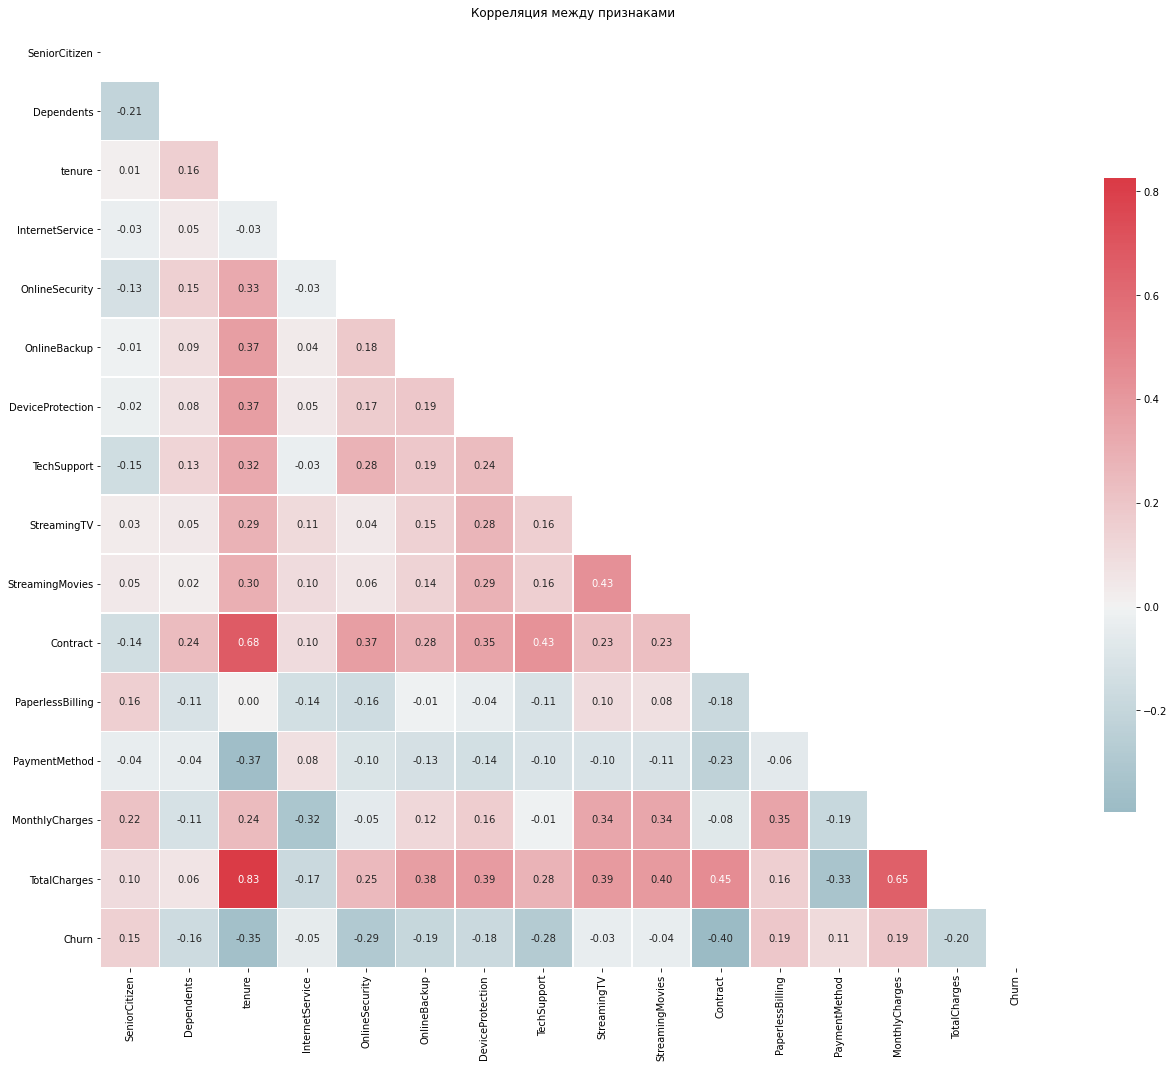

In [42]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, square=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Корреляция между признаками')
plt.tight_layout()
plt.show()

In [43]:
corr_threshold = 0.6
corr_features, corr_pairs = corr_features_with_threshold(corr, corr_threshold)
corr_features.append(target)

Признак tenure положительно коррелирует с признаком Contract с коэффициентом 0.6758762700696934
Признак tenure положительно коррелирует с признаком TotalCharges с коэффициентом 0.8252930182296665
Признак MonthlyCharges положительно коррелирует с признаком TotalCharges с коэффициентом 0.6505400607470732


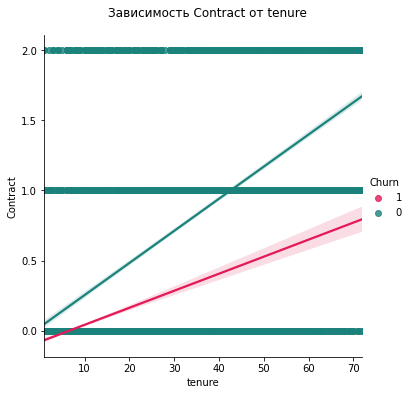

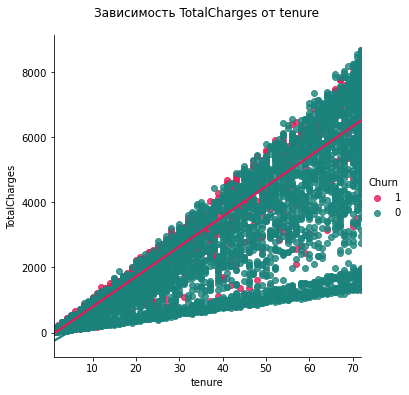

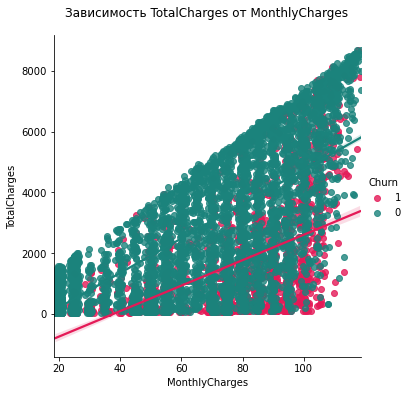

In [44]:
plot_correlations(corr_pairs, data)

<a id="utils"></a>
# Утилиты [⇑](#toc)

<a id="metrics"></a>
### Метрики [⇑](#toc)

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, jaccard_score

In [46]:
def float_fmt(flt):
    """Форматирует вывод вещественных чисел с тремя знаками после запятой"""
    return f'{flt:.3f}'

def metrics(y_true, y_pred, y_score, round=True, decimals=4):
    stats = [
        roc_auc_score(y_true, y_score)
       ,average_precision_score(y_true, y_score)
       ,precision_score(y_true, y_pred)
       ,recall_score(y_true, y_pred)
       ,f1_score(y_true, y_pred)
       ,accuracy_score(y_true, y_pred)
       ,jaccard_score(y_true, y_pred)
    ]
    
    return np.around(stats, decimals=decimals) if round else stats
    
measured_metrics = pd.DataFrame(index=[
     'ROC AUC'
    ,'Avg. Precision'
    ,'Precision'
    ,'Recall'
    ,'F1-score'
    ,'Accuracy'
    ,'Jaccard'
])

def clear_metrics():
    measured_metrics = pd.DataFrame(index=[
         'ROC AUC'
        ,'Avg. Precision'
        ,'Precision'
        ,'Recall'
        ,'F1-score'
        ,'Accuracy'
        ,'Jaccard'
    ]) 
    
def show_metrics(sortBy='ROC AUC'):
    def highlight_best_score(data):
        attr = 'color: green'
        is_best = data == data.max()
        return [attr if v else '' for v in is_best]
    
    display(measured_metrics.T.sort_values(by=sortBy, ascending=False).style.format('{:.4f}').apply(highlight_best_score))

<a id="mlplot"></a>
### Визуализация результатов моделирования [⇑](#toc)

In [47]:
from tqdm.auto import tqdm

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

palette = ['#ff5e5b', '#3bce62', '#ffed66', '#00cecb', '#809693', '#bce378', '#a8504d']
sns.set_palette(palette)

def random_search(classifier, param_distributions, name):
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    rscv = RandomizedSearchCV(classifier, 
                              param_distributions=param_distributions,
                              cv=cv,  
                              n_iter = 10,
                              scoring = 'roc_auc', 
                              error_score = 0, 
                              n_jobs = -1,
                              random_state=random_state)
    rscv.fit(X_train, y_train)
    print(f'Параметры лучшей модели {name}')
    display(rscv.best_params_)
    return rscv.best_estimator_

def compare_classifiers(classifiers):
    fig = plt.figure(constrained_layout=False, figsize=(21, 15), dpi=300)
    
    gs = GridSpec(5, 6, figure=fig)
    roc_ax   = fig.add_subplot(gs[0:2, 0:3])
    pr_ax    = fig.add_subplot(gs[0:2, 3:])
    roc_t_ax = fig.add_subplot(gs[2:4, 0:3])
    pr_t_ax  = fig.add_subplot(gs[2:4, 3:])
    
    cmap = sns.color_palette("rocket", as_cmap=True)

    col = 0
    progress = tqdm(classifiers, total=len(classifiers), position=0)
    for name, estimator, params in progress:
        progress.set_postfix_str(name)
        
        if params != None:
            name = f'{name}+cv'
            estimator = random_search(estimator, params, name)
        else:
            estimator.fit(X_train, y_train)

        y_pred_train = estimator.predict(X_train)
        y_pred_test  = estimator.predict(X_test)
        y_score_test = estimator.predict_proba(X_test)[:,1]
        
        measured_metrics[name] = metrics(y_test, y_pred_test, y_score_test)
        
        roc_display   = plot_roc_curve(estimator, X_test, y_test, name=name, ax=roc_ax, alpha=0.8)
        pr_display    = plot_precision_recall_curve(estimator, X_test, y_test, name=name, ax=pr_ax, alpha=0.8)
        roc_t_display = plot_roc_curve(estimator, X_train, y_train, name=name,  ax=roc_t_ax, alpha=0.8)
        pr_t_display  = plot_precision_recall_curve(estimator, X_train, y_train, name=name,  ax=pr_t_ax, alpha=0.8)
        
        roc_ax.set_title('ROC AUC — тестовая выборка')
        roc_t_ax.set_title('ROC AUC — тренировочная выборка')
        pr_ax.set_title('Precision-Recall — тестовая выборка')
        pr_t_ax.set_title('Precision-Recall — тренировочная выборка')
        
        if name != 'Baseline':
            c_ax = fig.add_subplot(gs[4, col])
            plot_confusion_matrix(estimator, X_test, y_test, ax=c_ax, normalize='true', cmap=cmap)
            c_ax.set_title(f'{name}')
            if col != 0:
                c_ax.set_xlabel('')
                c_ax.set_ylabel('')
            col+=1

    plt.tight_layout()
    plt.show()
    
    show_metrics()

<a id="ml"></a>
# Моделирование [⇑](#toc)

In [48]:
# Sklearm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

# XGBoost
from xgboost import XGBClassifier

# CatBoost
from catboost import CatBoostClassifier

# LightGBM
from lightgbm import LGBMClassifier

<a id="split"></a>
## Разбиение данных на тестовую и обучающую выборки [⇑](#toc)

In [49]:
from sklearn.model_selection import train_test_split

X = data.drop([target], axis=1)
y = data[target]
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

<a id="baseline"></a>
## Точка отсчёта [⇑](#toc)

На основании [распределения целевой](#targ_dist) переменной в качестве точки отсчёта выберу "классификатор", всё время предсказывающий лояльность абонента.

In [50]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_array, check_is_fitted

class BaselineClassifier(ClassifierMixin, BaseEstimator):
    """
    Всегда предсказывает наиболее частотный класс из тестовой выборки.
    """
    def fit(self, X, y):
        self.classes_ = unique_labels(y)
        self.most_frequent_target = pd.Series(y).value_counts().idxmax()
        self.proba = [1.0 if c == self.most_frequent_target else 0.0 for c in self.classes_]
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.full(len(X), self.most_frequent_target)
    
    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.full((len(X), len(self.classes_)), self.proba)

<a id="oob"></a>
## Моделирование с параметрами из коробки [⇑](#toc)

In [51]:
classifiers = [
    ('Baseline', BaselineClassifier()                                       , None),
    ('AdaBoost', AdaBoostClassifier(random_state=random_state)              , None),
    ('GB'      , GradientBoostingClassifier(random_state=random_state)      , None),
    ('HistGB'  , HistGradientBoostingClassifier(random_state=random_state)  , None),
    ('XGB'     , XGBClassifier(n_jobs=-1, random_state=random_state)        , None),
    ('CatBoost', CatBoostClassifier(random_seed=random_state, verbose=False), None),
    ('LightGBM', LGBMClassifier(n_jobs=-1, random_state=random_state)       , None)
]

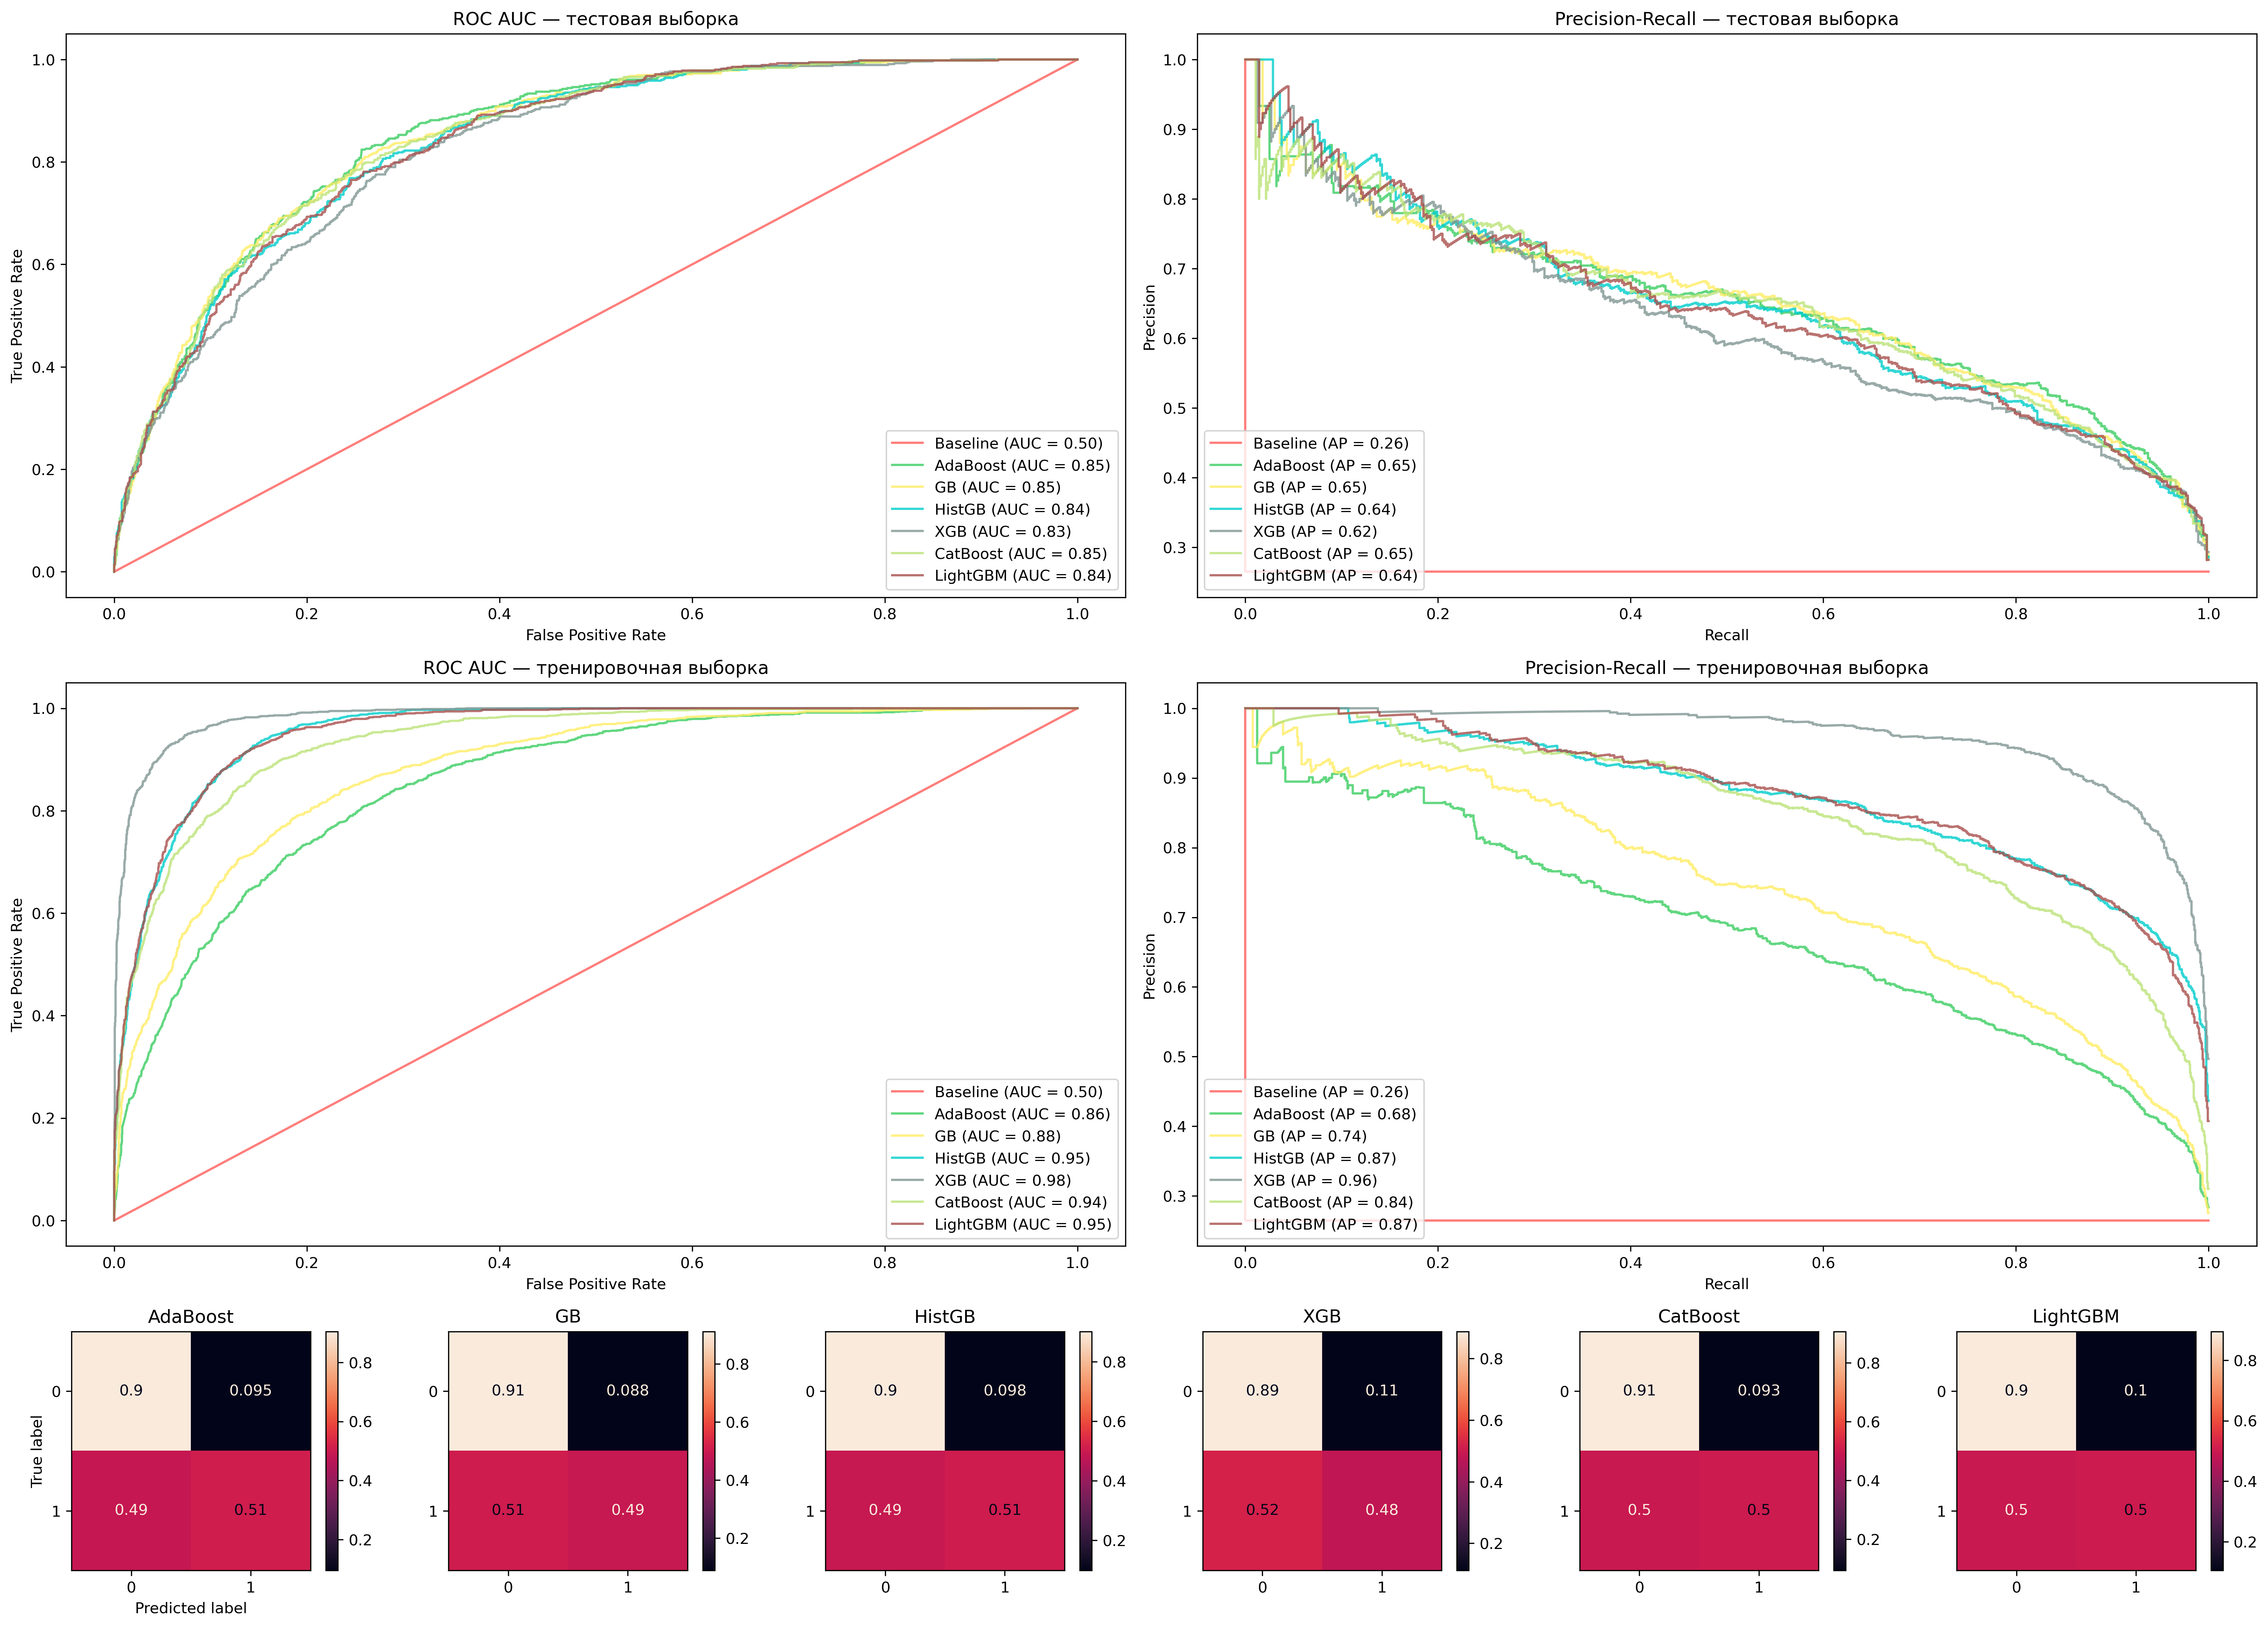

In [52]:
compare_classifiers(classifiers)

Неожиданно победила бабушка градиентного бустинга!

<a id="search_cv"></a>
## Подбор параметров моделей с помощью RandomizedSearchCV [⇑](#toc)

In [53]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
ada_params = {
    'n_estimators' : [50, 100, 300, 500, 700, 800, 1000],
    'learning_rate': [0.02, 0.03, 0.05, 0.1, 0.2],
}

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
gb_params = {
    'n_estimators' : [100, 300, 500, 700, 800, 1000],
    'learning_rate': [0.02, 0.03, 0.05, 0.1, 0.2],
    'subsample'    : [1, 0.9, 0.5, 0.3, 0.1],
    'max_depth'    : [3, 4, 6, 8],
    'loss'         : ['deviance', 'exponential'],
    'max_features' : [None, 2, 4, 8, 12]
}

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier
hgb_params = {
    'max_iter'         : [100, 300, 500, 700, 800, 1000],
    'learning_rate'    : [0.02, 0.03, 0.05, 0.1, 0.2],
    'max_depth'        : [3, 4, 6, 8, None],
    'l2_regularization': [0.0, 0.01, 0.05, 0.1]
}

# https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster
xgb_params = {
    'booster'         : ['gbtree', 'dart'],
    'n_estimators'    : [100, 300, 500, 700, 800, 1000],
    'learning_rate'   : [0.02, 0.03, 0.05, 0.1, 0.2],
    'subsample'       : [1, 0.9, 0.5, 0.3, 0.1],
    'max_depth'       : [3, 4, 6, 8],
    'colsample_bytree': [0.3, 0.4, 0.5 , 0.7, 0.9],
    'min_child_weight': [1, 2, 3, 4, 5, 7],
    'gamma'           : [0.0, 0.1, 0.2 , 0.3, 0.4],
    'reg_alpha'       : [0.0, 0.01, 0.05, 0.1, 1, 2],
    'reg_lambda'      : [0.0, 0.01, 0.05, 0.1, 1, 2]
}

# https://catboost.ai/docs/concepts/parameter-tuning.html
cat_params = {
    'iterations'         : [100, 300, 500, 700, 800, 1000],
    'learning_rate'      : [0.02, 0.03, 0.05, 0.1, 0.2],
    'depth'              : [3, 4, 6, 8, 10],
    'l2_leaf_reg'        : [0.0, 0.01, 0.05, 0.1, 1, 2],
    'sampling_unit'      : ['Object', 'Group'],
    'bagging_temperature': [0, 0.5, 1, 5, 10, 50],
}

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
lgbm_params = {
    'boosting_type': ['dart', 'gbdt', 'goss'],
    'n_estimators' : [100, 300, 500, 700, 800, 1000],
    'learning_rate': [0.02, 0.03, 0.05, 0.1, 0.2],
    'subsample'    : [1, 0.9, 0.5, 0.3, 0.1],
    'max_depth'    : [3, 4, 6, 8, 10, 20, -1],
    'reg_alpha'    : [0.0, 0.01, 0.05, 0.1, 1, 2],
    'reg_lambda'   : [0.0, 0.01, 0.05, 0.1, 1, 2],
    'num_leaves'   : [15, 31, 63, 127],
    'min_child_samples': [20, 50, 100, 300]
}

In [54]:
classifiers = [
    ('AdaBoost', AdaBoostClassifier(random_state=random_state)              , ada_params),
    ('GB'      , GradientBoostingClassifier(random_state=random_state)      , gb_params),
    ('HistGB'  , HistGradientBoostingClassifier(random_state=random_state)  , hgb_params),
    ('XGB'     , XGBClassifier(n_jobs=-1, random_state=random_state)        , xgb_params),
    ('CatBoost', CatBoostClassifier(random_seed=random_state, verbose=False), cat_params),
    ('LightGBM', LGBMClassifier(n_jobs=-1, random_state=random_state)       , lgbm_params)
]

Параметры лучшей модели AdaBoost+cv


{'n_estimators': 800, 'learning_rate': 0.03}

Параметры лучшей модели GB+cv


{'subsample': 0.5,
 'n_estimators': 100,
 'max_features': 8,
 'max_depth': 3,
 'loss': 'exponential',
 'learning_rate': 0.05}

Параметры лучшей модели HistGB+cv


{'max_iter': 300,
 'max_depth': 3,
 'learning_rate': 0.03,
 'l2_regularization': 0.01}

Параметры лучшей модели XGB+cv


{'subsample': 0.5,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'n_estimators': 300,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.03,
 'gamma': 0.1,
 'colsample_bytree': 0.4,
 'booster': 'dart'}

Параметры лучшей модели CatBoost+cv


{'sampling_unit': 'Object',
 'learning_rate': 0.02,
 'l2_leaf_reg': 0.01,
 'iterations': 300,
 'depth': 3,
 'bagging_temperature': 10}

Параметры лучшей модели LightGBM+cv


{'subsample': 0.3,
 'reg_lambda': 0.1,
 'reg_alpha': 0.1,
 'num_leaves': 15,
 'n_estimators': 700,
 'min_child_samples': 50,
 'max_depth': -1,
 'learning_rate': 0.02,
 'boosting_type': 'dart'}

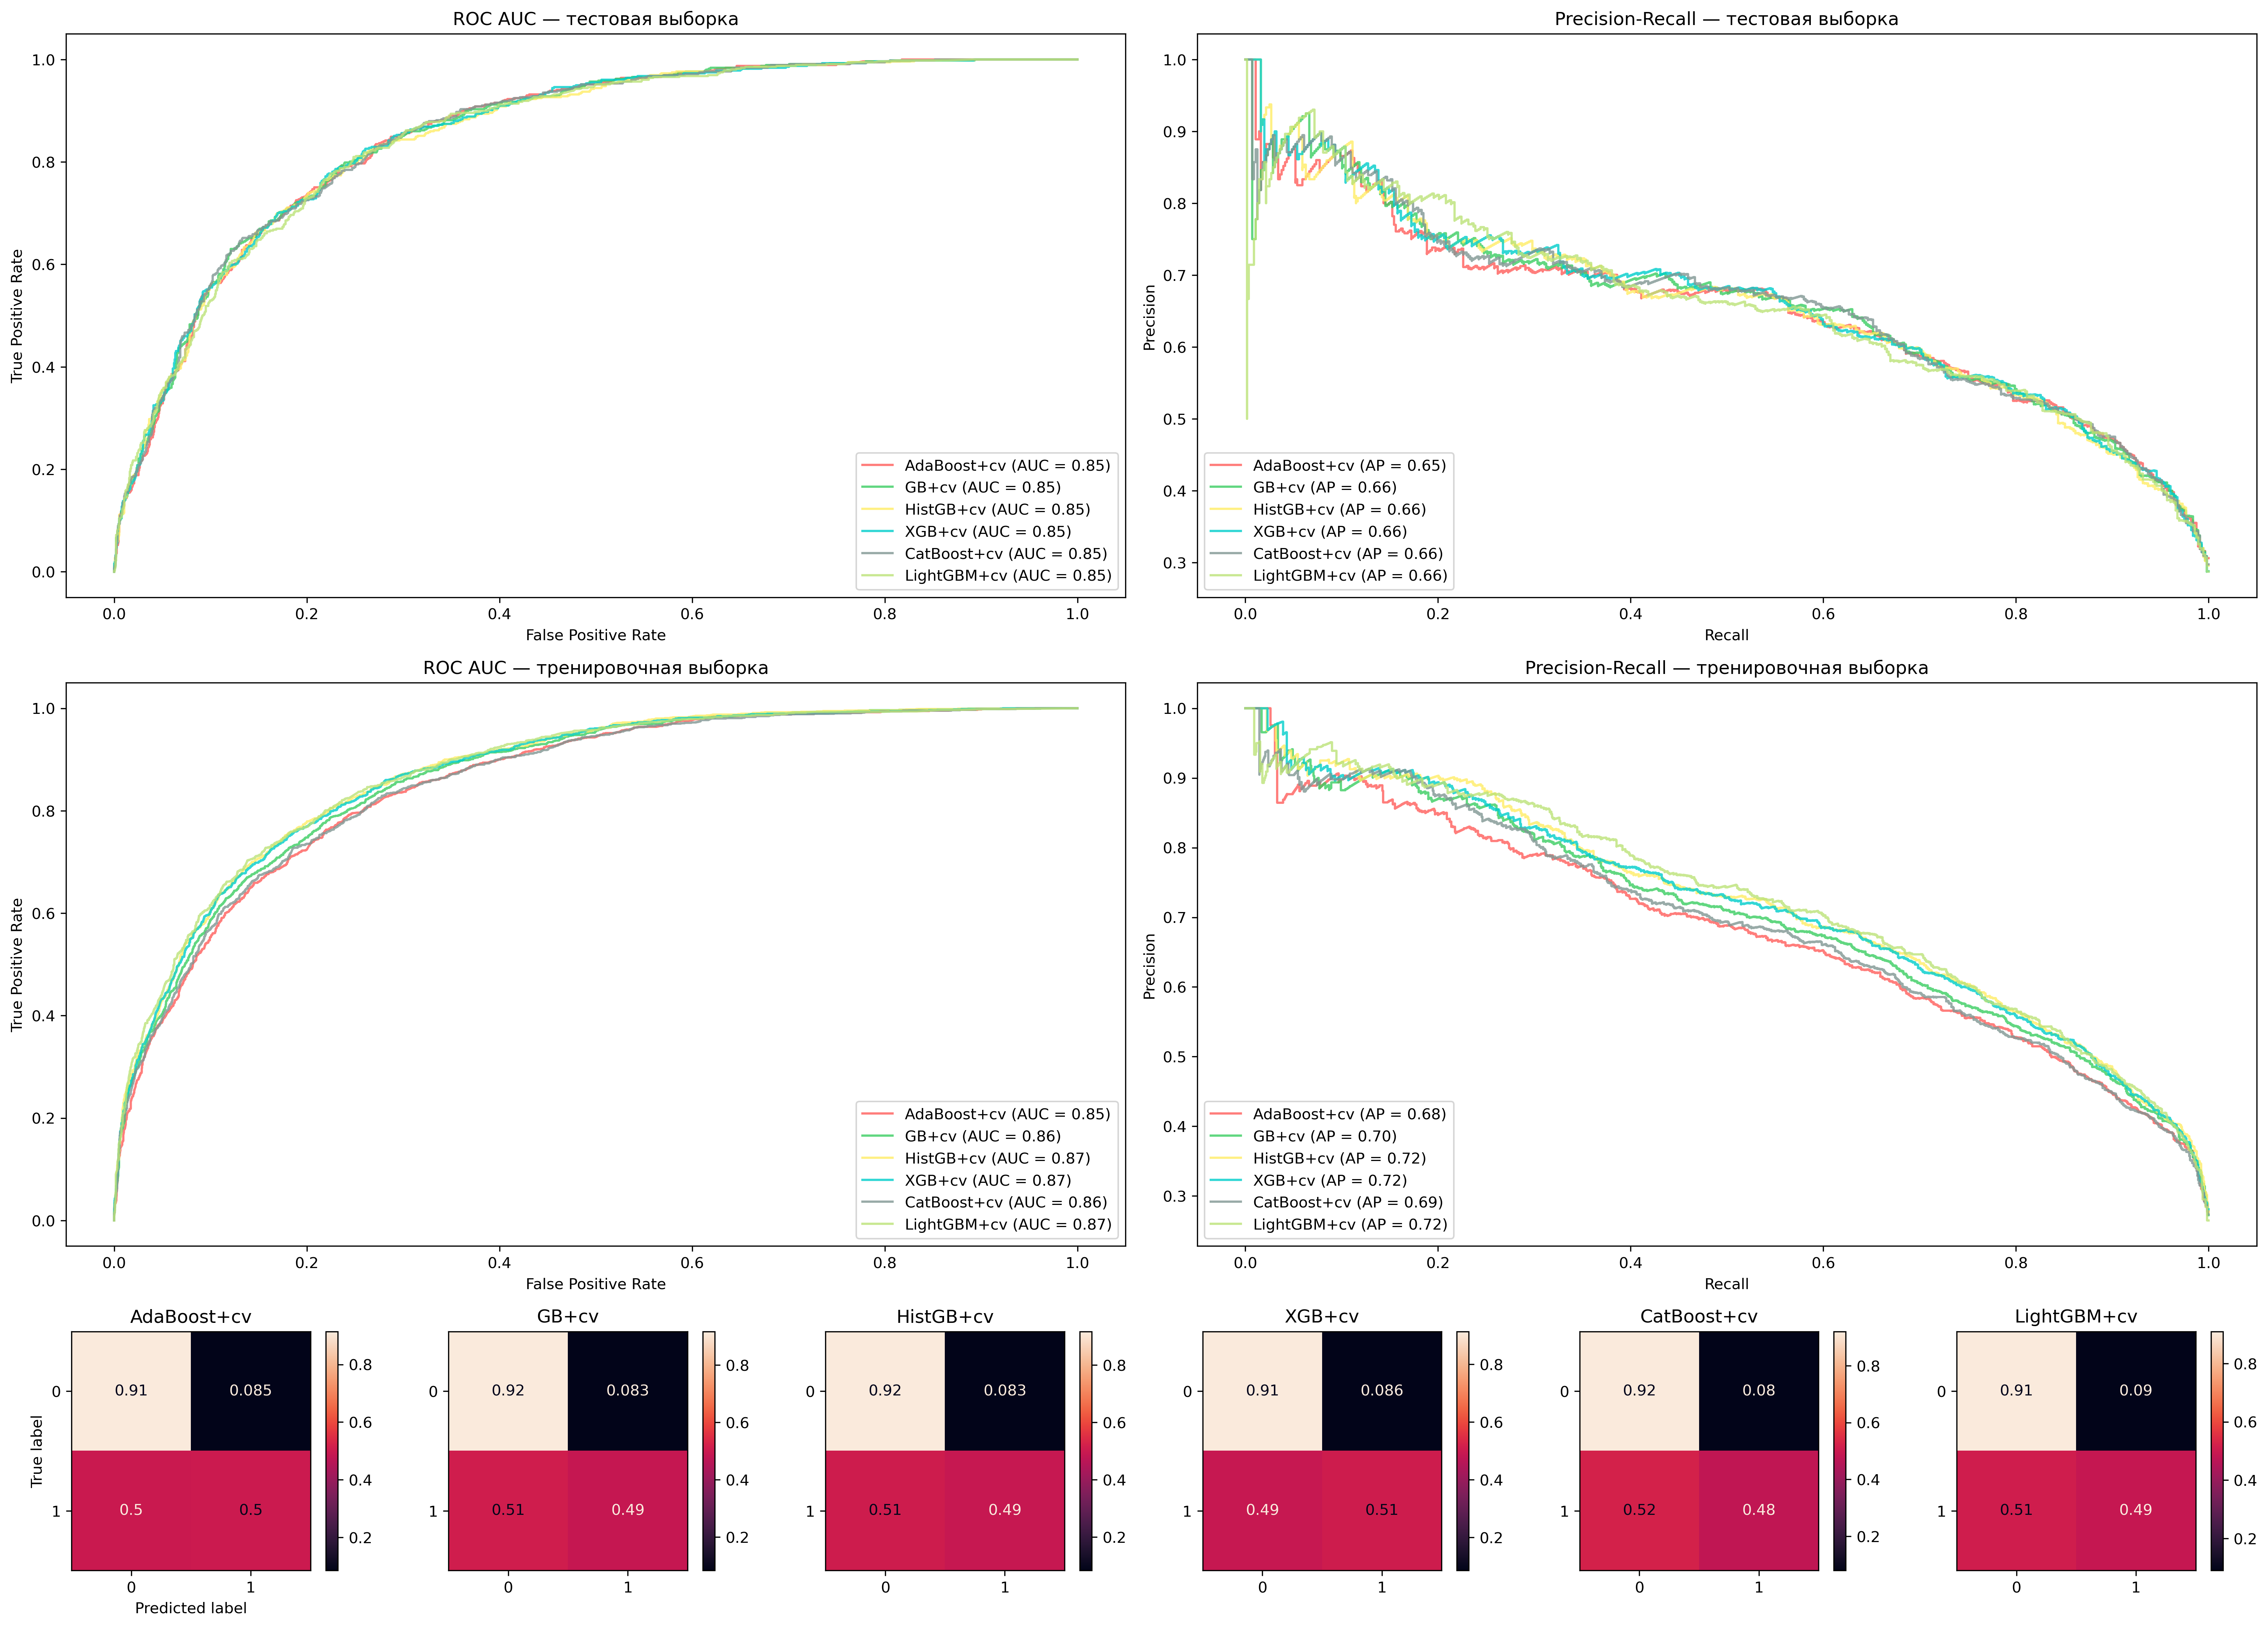

In [55]:
compare_classifiers(classifiers)

Победили котики! :)
Интересно, что по ROC AUC AdaBoost из коробки уступила лишь в третьем знаке после запятой!